# Notebook 2: SVM con Margen Suave

### Introducción

El SVM con margen suave es una extensión del SVM que permite clasificar datos que no son linealmente separables. En este caso, se permite que algunos puntos de entrenamiento estén dentro del margen de separación. Para ello, se introduce una variable de holgura que permite que algunos puntos de entrenamiento estén dentro del margen de separación.

Controlado por el hiperparámetro C, el SVM con margen suave busca minimizar el error de clasificación y el tamaño del margen de separación.

### Importación de Librerías

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

### Generación de Datos con Ruido

In [14]:
# Semilla para reproducibilidad
np.random.seed(42)
# Número de muestras por clase
N = 50
# Datos de la clase positiva
X_pos = np.random.randn(N, 2) + [2, 2]
# Datos de la clase negativa
X_neg = np.random.randn(N, 2) + [-2, -2]
# Combinar los datos
X = np.vstack((X_pos, X_neg))
y = np.hstack((np.ones(N), -np.ones(N)))

# Agregar outliers a los datos
outliers_pos = np.random.randn(5, 2) + [-2, -2]
outliers_neg = np.random.randn(5, 2) + [2, 2]
X_outliers = np.vstack((outliers_pos, outliers_neg))
y_outliers = np.hstack((np.ones(5), -np.ones(5)))
# Datos finales con outliers
X = np.vstack((X, X_outliers))
y = np.hstack((y, y_outliers))


### División de datos en entrenamiento y prueba

In [15]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Visualización de los Datos

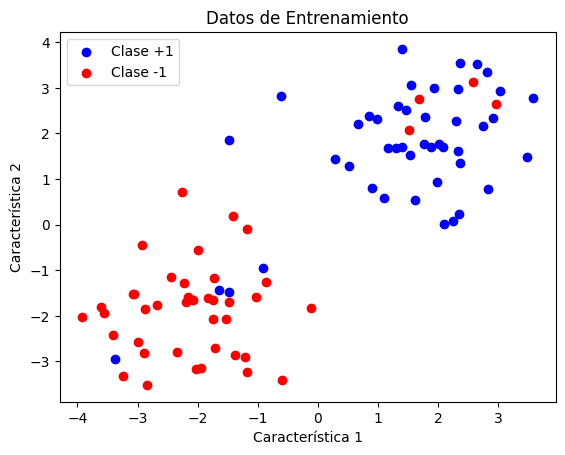

In [16]:
plt.scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], color='b', label='Clase +1')
plt.scatter(X_train[y_train==-1][:, 0], X_train[y_train==-1][:, 1], color='r', label='Clase -1')
plt.legend()
plt.title('Datos de Entrenamiento')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()

## Implementación del SVM con Margen Suave

### Formulación del problema

Queremos resolver el siguiente problema de optimización:

\begin{equation}
\min_{w, b, \xi} \frac{1}{2}||w||^2 + C\sum_{i=1}^{n}\xi_i
\end{equation}

Sujeto a las restricciones:

\begin{equation}
y_i(w^Tx_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0
\end{equation}

### Resolución del Problema

Usaremos el método del subgradiente estocástico para optimizar el problema.

In [17]:
def fit_svm_soft(X, y, C, epochs=1000, lr=0.001):
    m, n = X.shape
    w = np.zeros(n)
    b = 0
    # Almacenaremos los índices de los vectores de soporte
    support_vectors_idx = []
    
    # Etiquetas ajustadas para índices
    y = y.astype(int)
    
    for epoch in range(epochs):
        for i in range(m):
            condition = y[i] * (np.dot(X[i], w) + b) >= 1
            if condition:
                # Actualizar w sin penalización
                w -= lr * w
            else:
                # Actualizar w y b con penalización
                w -= lr * (w - C * y[i] * X[i])
                b -= lr * (-C * y[i])
                support_vectors_idx.append(i)
    
    # Asegurarnos de que los índices sean únicos
    support_vectors_idx = np.unique(support_vectors_idx)
    
    return w, b, support_vectors_idx


## Entrenamiento del Modelo

Seleccionaremos diferentes valores de 𝐶 para observar su efecto.

In [24]:
C_values = [0.1, 1, 10]
models = []

for C in C_values:
    w, b, support_vectors_idx = fit_svm_soft(X_train, y_train, C)
    models.append({'C': C, 'w': w, 'b': b, 'support_vectors_idx': support_vectors_idx})
    print(f"Modelo entrenado con C={C}")

Modelo entrenado con C=0.1
Modelo entrenado con C=1
Modelo entrenado con C=10


## Evaluación del Modelo

Evaluamos el rendimiento de los modelos en los conjuntos de entrenamiento y prueba.


In [26]:
def evaluate_model(X, y, w, b):
    y_pred = np.dot(X, w) + b
    y_true = y.astype(int)
    
    # Calculamos y_i (w^T x_i + b)
    decision_values = y_true * y_pred
    
    # Categorías
    correct_outside_margin = np.sum(decision_values >= 1)
    correct_inside_margin = np.sum((decision_values > 0) & (decision_values < 1))
    misclassified = np.sum(decision_values <= 0)
    
    total = len(y)
    print(f"Total de muestras: {total}")
    print(f"Correctamente clasificadas y fuera del margen: {correct_outside_margin}")
    print(f"Correctamente clasificadas pero dentro del margen: {correct_inside_margin}")
    print(f"Incorrectamente clasificadas: {misclassified}")
    
    # Retornar las métricas por si se necesitan
    return {
        'total': total,
        'correct_outside_margin': correct_outside_margin,
        'correct_inside_margin': correct_inside_margin,
        'misclassified': misclassified
    }


In [31]:
for C in C_values:
    print(f"__Modelo con C={C}__")
    # Evaluar en el conjunto de entrenamiento
    print("**Evaluación en el conjunto de entrenamiento:**")
    train_metrics = evaluate_model(X_train, y_train, models[C_values.index(C)]['w'], models[C_values.index(C)]['b'])
    
    # Evaluar en el conjunto de prueba
    print("**Evaluación en el conjunto de prueba:**")
    test_metrics = evaluate_model(X_test, y_test, models[C_values.index(C)]['w'], models[C_values.index(C)]['b'])
    print()

__Modelo con C=0.1__
**Evaluación en el conjunto de entrenamiento:**
Total de muestras: 88
Correctamente clasificadas y fuera del margen: 1
Correctamente clasificadas pero dentro del margen: 79
Incorrectamente clasificadas: 8
**Evaluación en el conjunto de prueba:**
Total de muestras: 22
Correctamente clasificadas y fuera del margen: 0
Correctamente clasificadas pero dentro del margen: 21
Incorrectamente clasificadas: 1

__Modelo con C=1__
**Evaluación en el conjunto de entrenamiento:**
Total de muestras: 88
Correctamente clasificadas y fuera del margen: 44
Correctamente clasificadas pero dentro del margen: 36
Incorrectamente clasificadas: 8
**Evaluación en el conjunto de prueba:**
Total de muestras: 22
Correctamente clasificadas y fuera del margen: 13
Correctamente clasificadas pero dentro del margen: 8
Incorrectamente clasificadas: 1

__Modelo con C=10__
**Evaluación en el conjunto de entrenamiento:**
Total de muestras: 88
Correctamente clasificadas y fuera del margen: 53
Correctamen

## Visualización de los Hiperplanos

In [32]:
def plot_svm(X, y, w, b, support_vectors_idx, C):
    plt.figure(figsize=(8,6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
    # Destacar los vectores de soporte
    plt.scatter(X[support_vectors_idx, 0], X[support_vectors_idx, 1], s=100, facecolors='none', edgecolors='k', label='Vectores de Soporte')
    
    # Crear una malla para dibujar los hiperplanos
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], 100)
    
    # Calcular la línea del hiperplano y los márgenes
    yy = -(w[0] * xx + b) / w[1]
    margin = 1 / np.linalg.norm(w)
    yy_down = yy - np.sqrt(1 + (w[0]/w[1])**2) * margin
    yy_up = yy + np.sqrt(1 + (w[0]/w[1])**2) * margin
    
    # Dibujar las líneas
    plt.plot(xx, yy, 'k-', label='Hiperplano de Decisión')
    plt.plot(xx, yy_down, 'k--', label='Márgenes')
    plt.plot(xx, yy_up, 'k--')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f'SVM con Margen Suave (C={C})')
    plt.legend()
    plt.xlabel('Característica 1')
    plt.ylabel('Característica 2')
    plt.show()


Visualizando modelo con C=0.1


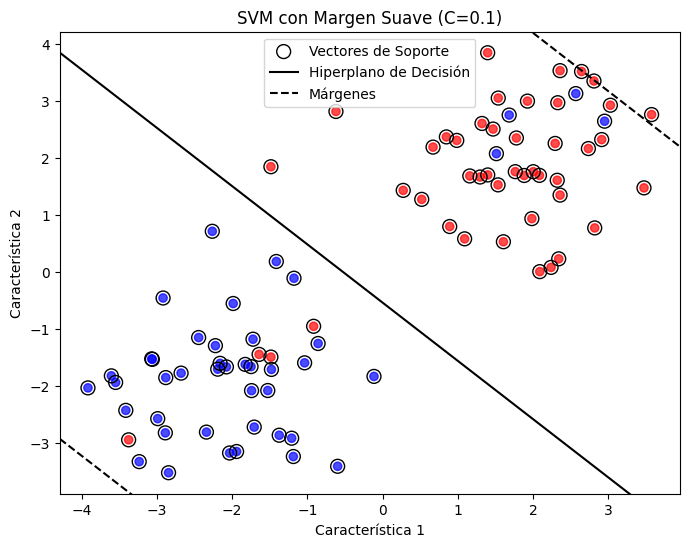

Visualizando modelo con C=1


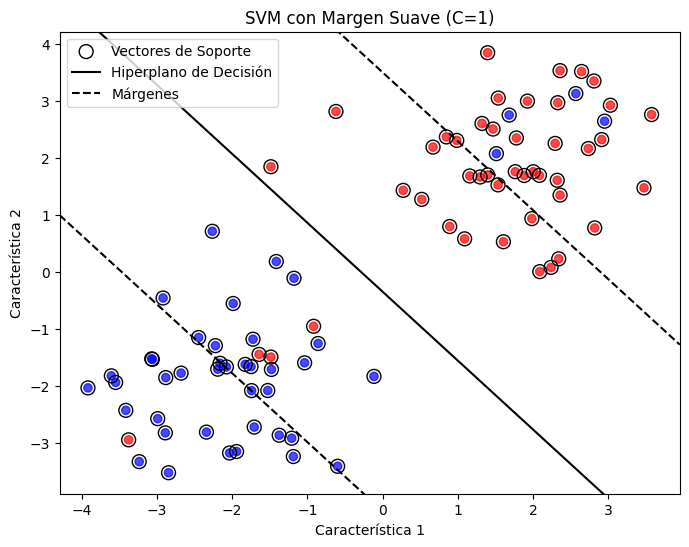

Visualizando modelo con C=10


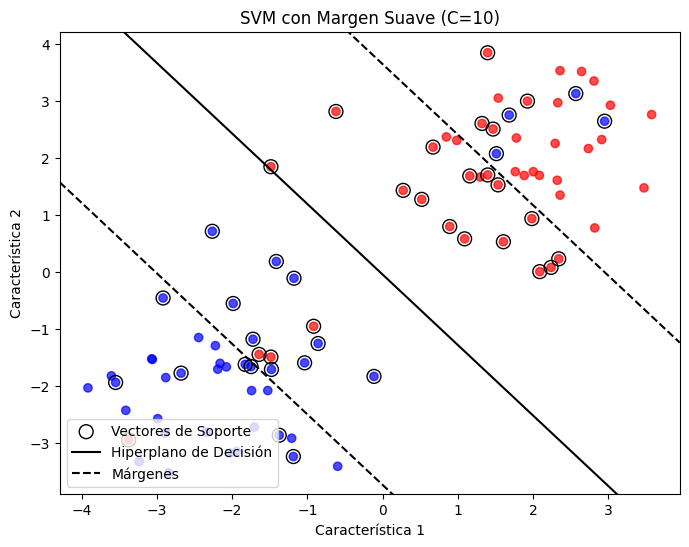

In [33]:
for model in models:
    C = model['C']
    w = model['w']
    b = model['b']
    support_vectors_idx = model['support_vectors_idx']
    print(f"Visualizando modelo con C={C}")
    plot_svm(X_train, y_train, w, b, support_vectors_idx, C)

## Seleccionar el mejor 𝐶

### Implementación de k-fold Cross Validation

In [35]:
from sklearn.model_selection import KFold

def cross_validation_C(X, y, C_values, k=5, epochs=1000, lr=0.001):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    C_errors = []
    
    for C in C_values:
        fold_errors = []
        for train_index, val_index in kf.split(X):
            X_train_cv, X_val_cv = X[train_index], X[val_index]
            y_train_cv, y_val_cv = y[train_index], y[val_index]
            
            # Entrenar el modelo en el fold de entrenamiento
            w, b, _ = fit_svm_soft(X_train_cv, y_train_cv, C, epochs=epochs, lr=lr)
            
            # Predecir en el fold de validación
            y_pred_val = np.sign(np.dot(X_val_cv, w) + b)
            error = np.mean(y_pred_val != y_val_cv)
            fold_errors.append(error)
        
        # Error promedio para este valor de C
        avg_error = np.mean(fold_errors)
        C_errors.append(avg_error)
        print(f"C={C}, Error de validación promedio: {avg_error:.4f}")
    
    return C_errors


### Selección de Valores de C para Evaluar

In [36]:
C_values = [0.01, 0.1, 1, 10, 100]
errors = cross_validation_C(X_train, y_train, C_values, k=5, epochs=1000, lr=0.001)

C=0.01, Error de validación promedio: 0.3222
C=0.1, Error de validación promedio: 0.1373
C=1, Error de validación promedio: 0.0902
C=10, Error de validación promedio: 0.1013
C=100, Error de validación promedio: 0.1569


### Gráfica de C vs Error

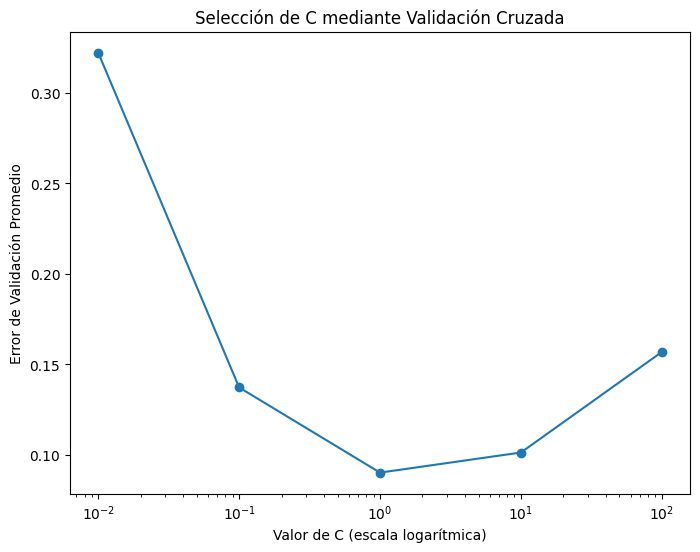

In [37]:
plt.figure(figsize=(8,6))
plt.plot(C_values, errors, marker='o')
plt.xscale('log')
plt.xlabel('Valor de C (escala logarítmica)')
plt.ylabel('Error de Validación Promedio')
plt.title('Selección de C mediante Validación Cruzada')
plt.show()

## Entrenar el Modelo con el Mejor C

Seleccionamos el valor de 𝐶 que produjo el menor error de validación promedio.

In [38]:
# Encontrar el valor de C con el menor error
best_C_index = np.argmin(errors)
best_C = C_values[best_C_index]
print(f"El mejor valor de C es: {best_C}")

# Entrenar el modelo final con el mejor C
w_best, b_best, support_vectors_idx_best = fit_svm_soft(X_train, y_train, best_C)

# Evaluar el modelo final
print("\nEvaluación del modelo final en el conjunto de prueba:")
test_metrics_best = evaluate_model(X_test, y_test, w_best, b_best)

El mejor valor de C es: 1

Evaluación del modelo final en el conjunto de prueba:
Total de muestras: 22
Correctamente clasificadas y fuera del margen: 13
Correctamente clasificadas pero dentro del margen: 8
Incorrectamente clasificadas: 1


### Visualización del modelo final


Visualizando el modelo final con C=1


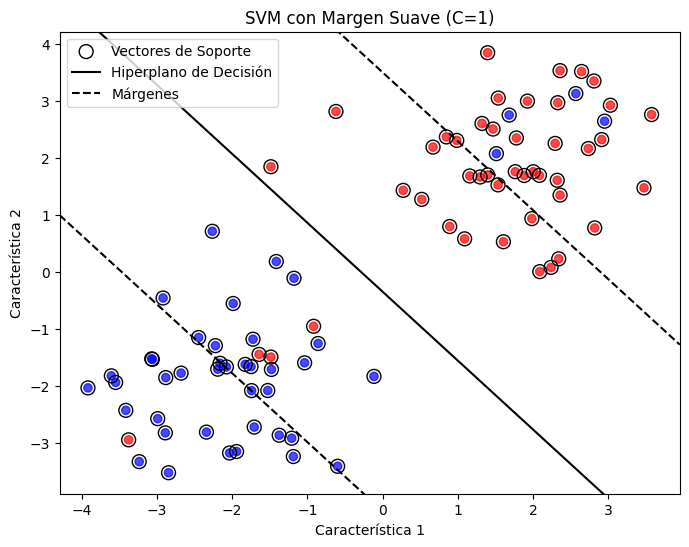

In [39]:
print(f"\nVisualizando el modelo final con C={best_C}")
plot_svm(X_train, y_train, w_best, b_best, support_vectors_idx_best, best_C)